In [ ]:
!pip install swig
!pip install "gymnasium[box2d]"
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 78.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 71.6 MB/s eta 0:00:00


Estado inicial: x=0.007426547817885876, y=1.41942298412323, 
vx=0.7522034049034119, vy=0.37787744402885437, 
theta=-0.00859864056110382, omega=-0.17038558423519135, 
left=0.0, right=0.0
-------------------------------------
Estado Final: x=1.1813409328460693, y=2.6637113094329834, 
vx=1.363344430923462, vy=-0.3898681104183197, 
theta=-0.971188485622406, omega=-0.1835431158542633, 
left=0.0, right=0.0


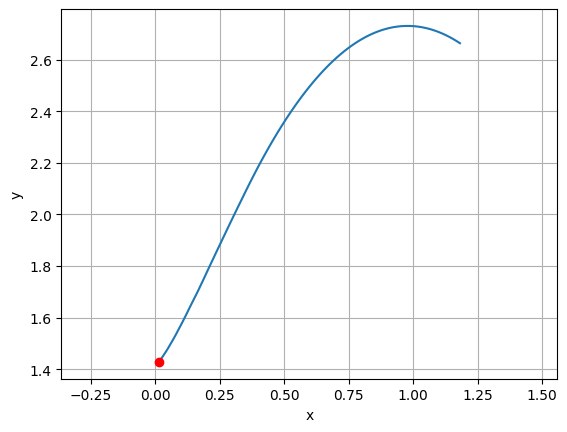

In [ ]:
#Exploremos por un momento el modelo del lunar lander
env = gym.make("LunarLander-v3", continuous=False, gravity=-10.0, enable_wind=False, wind_power=10.0, turbulence_power=1.5, render_mode='rgb_array')
#Action space
#0: do nothing
#1: fire left orientation engine
#2: fire main engine
#3: fire right orientation engine

#State space: The state is an 8-dimensional vector:
#the coordinates of the lander in x and y,
#its linear velocities in x and y,
#its angle, its angular velocity,
#and two booleans that represent whether each leg is in contact with the ground or not.

obs, info=env.reset()
x,y,vx,vy,theta,w1, left, right=obs
vecX=[]
vecY=[]
print(f"Estado inicial: x={x}, y={y}, \nvx={vx}, vy={vy}, \ntheta={theta}, omega={w1}, \nleft={left}, right={right}")
for i in range(100):
  acc=2
  if i>40:
    acc=0
  obs, reward, terminated, truncated, info = env.step(acc) #Disparamos el cohete principal
  x,y,vx,vy,theta,w1, left, right=obs
  vecX.append(x)
  vecY.append(y)
print(f"-------------------------------------\nEstado Final: x={x}, y={y}, \nvx={vx}, vy={vy}, \ntheta={theta}, omega={w1}, \nleft={left}, right={right}")
plt.plot(vecX,vecY)
plt.xlabel('x')
plt.ylabel('y')
plt.plot(vecX[0],vecY[0],'or')
plt.axis('equal')
plt.grid()


In [ ]:
!pip install imageio[ffmpeg]
st, info=env.reset()
import imageio
frames = []
x,y=[st[0]], [st[1]]
vx, vy=[],[]
flag=True
contador=0
while(flag and contador<100):
  action=np.random.choice(a=[0,1,2,3], p=[0.4, 0.1, 0.4, 0.1])
  observation, reward, terminated, truncated, info = env.step(action)
  fr=env.render()
  frames.append(fr)
  if terminated or truncated:
    flag=False
  x.append(observation[0])
  y.append(observation[1])
  vx.append(observation[2])
  vy.append(observation[3])
  st=observation
  contador+=1
num=np.random.randint(1000)
output_path = "animacion"+str(num)+".mp4"
imageio.mimsave(output_path, frames, fps=20)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
if os.path.exists('/content/drive/MyDrive/modelosNN/policy_net.pth'):
  !cp '/content/drive/MyDrive/modelosNN/policy_net.pth' './policy_net.pth'
else:
  print('No se encontró el archivo')

In [ ]:
import random
import numpy as np
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
# ==============================
# 1. Red neuronal para DQN
# ==============================
class DQNNet(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQNNet, self).__init__()
        self.fc1 = nn.Linear(state_size, 256)  # Más capacidad
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, action_size)

    def forward(self, x):
        # En algunos entornos, BatchNorm requiere batch > 1
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        return self.fc4(x)



In [ ]:
# ==============================
# 2. Buffer de experiencia
# ==============================
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*batch)
        return (np.array(state),
                np.array(action),
                np.array(reward, dtype=np.float32),
                np.array(next_state),
                np.array(done, dtype=np.uint8))

    def __len__(self):
        return len(self.buffer)


In [ ]:
# ==============================
# 3. Agente DQN
# ==============================
import os

class DQNAgent:
    def __init__(self, state_size, action_size, gamma=0.99, lr=1e-3, buffer_size=10000, batch_size=128, tau=0.005):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.batch_size = batch_size
        self.tau = tau
        self.update_every=64
        self.contador=0
        self.error=[]
        # Redes neuronal principal y objetivo
        if os.path.exists('policy_net.pth'):
            state_dict = torch.load('policy_net.pth', map_location='cuda' if torch.cuda.is_available() else 'cpu')
        else:
            state_dict = None
        self.policy_net = DQNNet(state_size, action_size)
        if(state_dict):
            print('Se cargó el entrenamiento previo')
            self.policy_net.load_state_dict(state_dict)
        self.policy_net.to(device)
        self.target_net = DQNNet(state_size, action_size)
        if(state_dict):
            self.target_net.load_state_dict(state_dict)
        self.target_net.to(device)
        self.target_net.eval()

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
        self.memory = ReplayBuffer(buffer_size)

    def select_action(self, state, epsilon=0.1): #Epsilon Greedy
        if random.random() < epsilon:
            return random.randrange(self.action_size)
        state = torch.tensor([state], dtype=torch.float32)
        with torch.no_grad():
            q_values = self.policy_net(state.to(device)).cpu()
        return int(torch.argmax(q_values).item())

    def store_transition(self, state, action, reward, next_state, done):
        self.memory.push(state, action, reward, next_state, done)

    def update(self):
        self.contador-=1
        if(self.contador>0):
            return
        else:
            self.contador=self.update_every
            #print('Update')
        if len(self.memory) < self.batch_size:
            return

        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)

        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(1)
        rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1)
        next_states = torch.tensor(next_states, dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1)

        # Q(s,a)
        q_values = self.policy_net(states.to(device)).gather(1, actions.to(device))

        # max Q'(s', a')
        with torch.no_grad():
            max_next_q = self.target_net(next_states.to(device)).max(1)[0].unsqueeze(1)
            target_q = rewards.to(device) + (1 - dones.to(device)) * self.gamma * max_next_q

        loss = nn.MSELoss()(q_values, target_q)
        self.error.append(loss.item())
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Actualización suave de la red objetivo
        for target_param, policy_param in zip(self.target_net.parameters(), self.policy_net.parameters()):
          target_param.data.copy_(self.tau * policy_param.data + (1.0 - self.tau) * target_param.data)


In [ ]:
# ==============================
# 4. Loop de entrenamiento
# ==============================
def train_dqn(agent, env, episodes=500, epsilon_start=1.0, epsilon_end=0.05, epsilon_decay=0.995):
    rwrd=[]
    epsilon = epsilon_start
    for episode in range(episodes):
        state, info = env.reset()
        done = False
        total_reward = 0

        while not done:
            action = agent.select_action(state, epsilon)
            next_state, reward, terminated, truncated, info = env.step(action)
            done=terminated or truncated
            #print(state, action, reward, next_state, done)
            agent.store_transition(state, action, reward, next_state, done)
            agent.update()

            state = next_state
            total_reward += reward
        rwrd.append(total_reward)
        epsilon = max(epsilon_end, epsilon * epsilon_decay)
        print(f"\rEpisode {episode+1}/{episodes}, Total Reward: {total_reward:.2f}, Epsilon: {epsilon:.3f}", end='')


In [ ]:
env = gym.make("LunarLander-v3", continuous=False, gravity=-10.0, enable_wind=False, wind_power=15.0, turbulence_power=1.5, render_mode='rgb_array')
obs, info=env.reset()

agent = DQNAgent(state_size=8, action_size=4)
num=100
train_dqn(agent, env, episodes=num, epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=np.power(0.01/1,1/num))

Se cargó el entrenamiento previo
Episode 1/100, Total Reward: -157.81, Epsilon: 0.955

/tmp/ipython-input-716471686.py:38: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  state = torch.tensor([state], dtype=torch.float32)


Episode 100/100, Total Reward: 259.94, Epsilon: 0.010

In [ ]:
len(agent.memory.buffer)

10000

In [ ]:
for elm in agent.memory.buffer[10]:
  print(elm)

[ 0.01433496  1.308969    0.16146182 -0.6027116  -0.01331739 -0.02884587
  0.          0.        ]
0
-1.3098567267243197
[ 0.01593504  1.2948083   0.16146602 -0.6293801  -0.01475933 -0.02884151
  0.          0.        ]
False


In [ ]:
!pip install imageio[ffmpeg]
st, info=env.reset()
import imageio
frames = []
x,y=[st[0]], [st[1]]
vx, vy=[],[]
flag=True
contador=0
while(flag and contador<5000):
  out=agent.policy_net(torch.tensor([st], dtype=torch.float32).to(device)).detach().cpu().numpy()[0]
  action=np.argmax(out)
  observation, reward, terminated, truncated, info = env.step(action)
  fr=env.render()
  frames.append(fr)
  if terminated or truncated:
    flag=False
  x.append(observation[0])
  y.append(observation[1])
  vx.append(observation[2])
  vy.append(observation[3])
  st=observation
  contador+=1

output_path = "animacion.mp4"
imageio.mimsave(output_path, frames, fps=10)

In [ ]:
torch.save(agent.policy_net.state_dict(), 'policy_net.pth')
!cp './policy_net.pth' '/content/drive/MyDrive/modelosNN/policy_net.pth'

In [ ]:
agent.policy_net(torch.tensor([0,10,0,100,0,0,0,0]).float().to(device))

tensor([4251.6528, 3766.4329, 3171.1116, 4151.5176], device='cuda:0',
       grad_fn=<ViewBackward0>)

In [ ]:
Q=agent.policy_net
so, info=env.reset()
acc=0
s1, reward, terminated, truncated, info = env.step(acc)
print('So:',so, '\nAcc:',acc, '\nS1',s1, '\nRecompensa:',reward, '\nFin:',terminated or truncated)
gamma=agent.gamma
A=reward+gamma*Q(torch.tensor(s1).float().to(device)).max()
print('A:',A)
B=Q(torch.tensor(so).float().to(device))[acc]
print('B:',B)
TD=A-B
print('TD:',TD)
TD.backward()

So: [ 0.00738058  1.4038624   0.74756116 -0.313702   -0.0085455  -0.16933379
  0.          0.        ] 
Acc: 0 
S1 [ 0.01476145  1.3962286   0.74655086 -0.33935145 -0.01691308 -0.16736692
  0.          0.        ] 
Recompensa: -1.013825295265093 
Fin: False
A: tensor(96.0798, device='cuda:0', grad_fn=<AddBackward0>)
B: tensor(96.3005, device='cuda:0', grad_fn=<SelectBackward0>)
TD: tensor(-0.2206, device='cuda:0', grad_fn=<SubBackward0>)
